## Coding

In [4]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd
df = pd.read_excel('fake_news.xlsx')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [18]:
df = df.dropna()

(20800, 5)

In [23]:
df['label'].value_counts()

label
0    10361
1     7920
Name: count, dtype: int64

In [24]:
import matplotlib.pyplot as plt

## Dataset Analysis

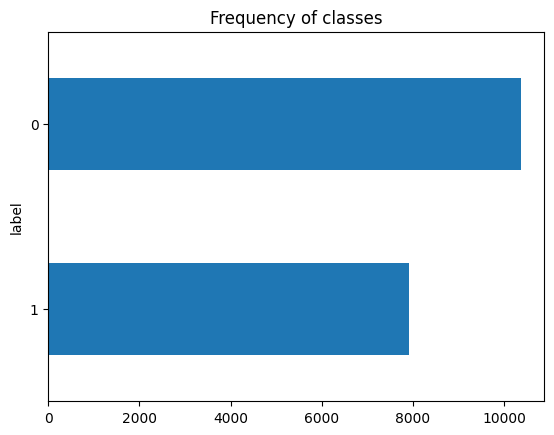

In [27]:
label_count = df['label'].value_counts(ascending=True)
label_count.plot.barh()
plt.title('Frequency of classes')
plt.show()

Text(0.5, 1.0, 'Text token')

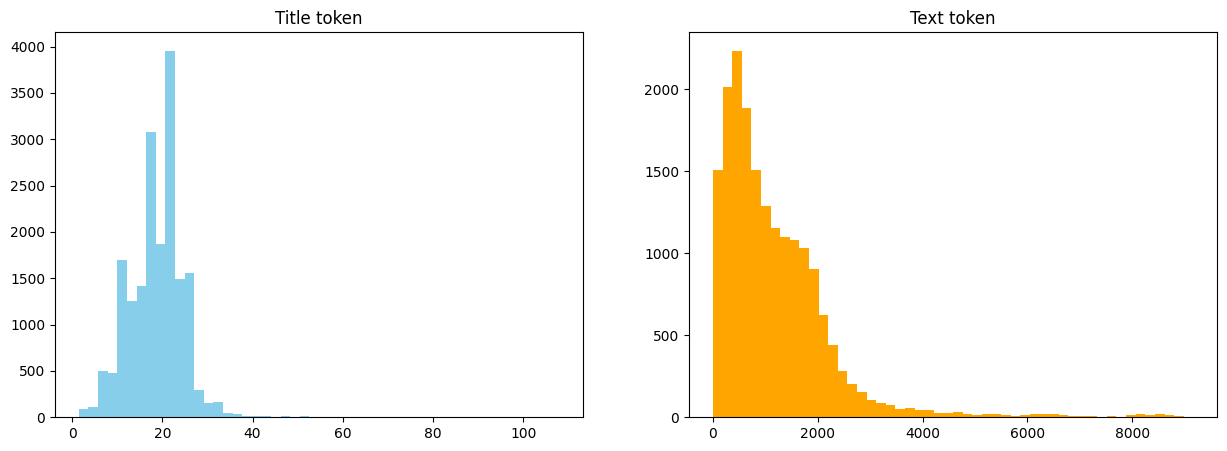

In [37]:
#BERT model has maximum input context size 512

df['title_token']= df['title'].apply(lambda x : len(x.split())*1.5)
df['text_token']= df['text'].apply(lambda x : len(x.split())*1.5)

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].hist(df['title_token'], bins=50, color = 'skyblue')
ax[0].set_title('Title token')

ax[1].hist(df['text_token'], bins=50, color = 'orange')
ax[1].set_title('Text token')

## Train test spilit

In [43]:
# 70% for training, 20% test, 10% validation
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])


train.shape, test.shape, validation.shape

((12796, 7), (3656, 7), (1829, 7))

### Transformer Dataset Conversion

In [47]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
        
    }
    
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 1829
    })
})

## Data Tokenisation 

In [49]:
from transformers import AutoTokenizer

text = "Lets have some fun with BERT encoder transformer !!"


model_ckpt = "distilbert-base-uncased"
distilbert_tokenisers = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens= distilbert_tokenisers.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenisers = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens= mobilebert_tokenisers.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenisers = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens= tinybert_tokenisers.tokenize(text)





In [50]:
distilbert_tokenisers, mobilebert_tokenisers, tinybert_tokenisers

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000

In [64]:
def tokenize(batch):
    temp = distilbert_tokenisers(batch['title'], padding=True, truncation=True)
    return temp

In [58]:
def tokenize_bert_type(batch,bert_tokenizer):
    temp = bert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

In [53]:
dataset['train'][0:2]

{'id': [1424, 6588],
 'title': ['Medical Study Shatters the Theory that Cannabis Acts as a Gateway Drug',
  'China Airport Security Robot Gives Electroshocks'],
 'author': ['Waking Times', 'Alex Ansary'],
 'text': ['Waking Times \nResearch reveals that cannabis may, in fact, serve as an effective exit drug for persons suffering from alcoholism or addiction to illicit or prescription drugs. A survey conducted by researchers at the University of British Columbia (UBC) found that addicts may benefit from using cannabis as a substitute to more dangerous and health-destroying substances, especially alcohol and prescription drugs. Cannabis may be a step towards fighting addiction. \n“Research suggests that people may be using cannabis as an exit drug to reduce use of substances that are potentially more harmful, such as opioid pain medication.” ~ Zach Walsh, Researcher and UBC Associate Professor of Psychology \nThe UBC study was conducted using a 414-question survey that was offered to medi

In [59]:
print(tokenize_bert_type(dataset['train'][0:2], distilbert_tokenisers))

{'input_ids': [[101, 2966, 2817, 27271, 2015, 1996, 3399, 2008, 17985, 4490, 2004, 1037, 11909, 4319, 102], [101, 2859, 3199, 3036, 8957, 3957, 16175, 22231, 10603, 102, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [61]:
print(tokenize_bert_type(dataset['train'][0:2], mobilebert_tokenisers))

{'input_ids': [[101, 2966, 2817, 27271, 2015, 1996, 3399, 2008, 17985, 4490, 2004, 1037, 11909, 4319, 102], [101, 2859, 3199, 3036, 8957, 3957, 16175, 22231, 10603, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [62]:
print(tokenize_bert_type(dataset['train'][0:2], tinybert_tokenisers))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 2966, 2817, 27271, 2015, 1996, 3399, 2008, 17985, 4490, 2004, 1037, 11909, 4319, 102], [101, 2859, 3199, 3036, 8957, 3957, 16175, 22231, 10603, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


##### tinyBERT & MobileBERT has 'token_type_ids' token which can be used sentence prediction 

In [65]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=None)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map: 100%|██████████| 1829/1829 [00:00<00:00, 2946.68 examples/s]


## Model Building

#### DistilBERT

In [75]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)





Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
model.config.id2label

{0: 'Real', 1: 'Fake'}

In [70]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.0",
  "vocab_size": 30522
}

#### MobileBERT

In [71]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "google/mobilebert-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
model.config

MobileBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transformers_version": "4.46.0",
  "trigram_input": true,
  "true_hidden_size": 128,
  "type_vocab_size": 2,
  "use_bottleneck": true,
  "use_bottleneck_attention

#### tinyBERT

In [73]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.46.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Model Fine tuning

<img src="Screenshot 2024-10-25 at 8.00.01 PM.png">

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

#### Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [78]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [79]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch'
)

In [80]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenisers
)

In [81]:
trainer.train()

 10%|█         | 500/4800 [06:51<52:19,  1.37it/s]  

{'loss': 0.2195, 'grad_norm': 11.995878219604492, 'learning_rate': 4.4791666666666673e-05, 'epoch': 0.31}


 21%|██        | 1000/4800 [22:41<44:22,  1.43it/s]  

{'loss': 0.1705, 'grad_norm': 4.640246391296387, 'learning_rate': 3.958333333333333e-05, 'epoch': 0.62}


 31%|███▏      | 1500/4800 [28:52<41:02,  1.34it/s]  

{'loss': 0.1555, 'grad_norm': 0.09536721557378769, 'learning_rate': 3.4375e-05, 'epoch': 0.94}


 42%|████▏     | 2000/4800 [35:12<34:05,  1.37it/s]  

{'loss': 0.1005, 'grad_norm': 0.10926896333694458, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


 52%|█████▏    | 2500/4800 [41:23<26:51,  1.43it/s]  

{'loss': 0.0773, 'grad_norm': 0.006749944761395454, 'learning_rate': 2.3958333333333334e-05, 'epoch': 1.56}


 62%|██████▎   | 3000/4800 [53:27<20:12,  1.49it/s]   

{'loss': 0.0714, 'grad_norm': 0.11187916994094849, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.88}


 73%|███████▎  | 3500/4800 [1:00:41<20:04,  1.08it/s]

{'loss': 0.0474, 'grad_norm': 0.007632969878613949, 'learning_rate': 1.3541666666666666e-05, 'epoch': 2.19}


 83%|████████▎ | 4000/4800 [1:06:58<09:27,  1.41it/s]

{'loss': 0.0262, 'grad_norm': 0.04356299340724945, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


 94%|█████████▍| 4500/4800 [1:13:40<03:41,  1.35it/s]

{'loss': 0.0248, 'grad_norm': 0.004622291307896376, 'learning_rate': 3.125e-06, 'epoch': 2.81}


100%|██████████| 4800/4800 [1:17:38<00:00,  1.03it/s]

{'train_runtime': 4658.7644, 'train_samples_per_second': 8.24, 'train_steps_per_second': 1.03, 'train_loss': 0.09452580610911052, 'epoch': 3.0}


TrainOutput(global_step=4800, training_loss=0.09452580610911052, metrics={'train_runtime': 4658.7644, 'train_samples_per_second': 8.24, 'train_steps_per_second': 1.03, 'total_flos': 273842194970064.0, 'train_loss': 0.09452580610911052, 'epoch': 3.0})